In [3]:
import tensorflow as tf         
from keras.layers import BatchNormalization, LeakyReLU, Add, Conv2D, Dense, Activation, Reshape
from keras.models import Input, Model
from keras.optimizers import Adam

from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
K.set_session(sess)
import os

if not os.path.isdir("./collected_data"):
    os.makedirs("./collected_data")
    
if not os.path.isdir("./collected_models"):
    os.makedirs("./collected_models")

import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image as IM

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

% matplotlib inline

In [3]:
num_image = 50000

In [4]:
def add_images_from_files_to_list(root, files, list, next_index, data_cb=None):
    if files and next_index < num_image:
        def identity(v):
            return v

        if data_cb is None:
            data_cb = identity

        for index, file in enumerate(files):
            if file.endswith('.png'):
                image = IM.load_img(os.path.join(root, file))
                if image is not None and next_index < num_image:
                    list[next_index] = data_cb(image.reshape((64, 64, 3)))
                    next_index += 1
                # list.append(data_cb(image[:, :, 0]))
    return next_index

In [5]:
images_train = np.empty((num_image, 64, 64, 3))
i = 0

In [6]:
for root, sub_directories, files in os.walk(""):
    if i < num_image:
        print(i)
        i = add_images_from_files_to_list(root, files, images_train, i)

# plt.subplot(96, 96)
# plt.imshow(images_train[20], interpolation='nearest', cmap='gray_r')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('./collected_data/gan_generated_image_epoch_%d.png' % 999)
# plt.clf()

In [7]:
# images_train = np.array(images_train)
# images_train = images_train.reshape((*images_train.shape, 1))
# images_train = images_train[:, :, :, :1]

In [8]:
dropout = 0.4
depth = 256
dim = 8
input_dim = 128
batch_size = 1
epochs = 200

In [9]:
class Subpixel(Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 r,
                 padding='same',
                 data_format=None,
                 strides=(1,1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Subpixel, self).__init__(
            filters=r*r*filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.r = r

    def _phase_shift(self, I):
        r = self.r
        bsize, a, b, c = I.get_shape().as_list()
        bsize = K.shape(I)[0] # Handling Dimension(None) type for undefined batch dim
        X = K.reshape(I, [bsize, a, b, int(c/(r*r)),r, r]) # bsize, a, b, c/(r*r), r, r
        X = K.permute_dimensions(X, (0, 1, 2, 5, 4, 3))  # bsize, a, b, r, r, c/(r*r)
        #Keras backend does not support tf.split, so in future versions this could be nicer
        X = [X[:,i,:,:,:,:] for i in range(a)] # a, [bsize, b, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, b, a*r, r, c/(r*r)
        X = [X[:,i,:,:,:] for i in range(b)] # b, [bsize, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, a*r, b*r, c/(r*r)
        return X

    def call(self, inputs):
        return self._phase_shift(super(Subpixel, self).call(inputs))

    def compute_output_shape(self, input_shape):
        unshifted = super(Subpixel, self).compute_output_shape(input_shape)
        return (unshifted[0], int(self.r*unshifted[1]), int(self.r*unshifted[2]), int(unshifted[3]/(self.r*self.r)))

    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop('rank')
        config.pop('dilation_rate')
        config['filters']/=int(self.r*self.r)
        config['r'] = self.r
        return config

In [43]:
class AnimeGeneratorFactory():
    def build(self, input_shape):
        """
            Returns a generator Model described here: https://arxiv.org/pdf/1708.05509.pdf

            Args:
                input_same: A 3 length tuple describing (width, height, channel)

            Output:
                Keras Model
        """
        MOMENTUM = 0.9
        DIM = 16
        DEPTH = 64
        NUM_RESIDUAL = 16
        NUM_SUBPIXEL = 2
        FINAL_FILTERS = 3
        INITIAL_FILTERS = 64

        def residual_block(layer, filters, momentum):
            """
                Residual Block consisting of
                    Conv2D -> Batch Normalization -> relu -> Conv2D -> Batch Normalization -> Residual Addition

                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """
            shortcut = layer
            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)
            layer = Activation("relu")(layer)
            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)
            

            layer = Add()([layer, shortcut])
            return layer

        def residual_layer(layer, number, filters, momentum):
            """
                Facade for residual block.

                Creates Residual layer with specified number of residual blocks

                Args:
                    layer:   Keras layer
                    number:  number of residual blocks in layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = residual_block(layer, filters, momentum)
            return layer

        def subpixel_block(layer, filters, momentum):
            """
                sub-pixel block consisting of
                    Conv2D -> pixel shuffler x 2 -> Batch Normalization -> Relu

                the code of subpixel layer is based on https://github.com/Tetrachrome/subpixel

                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """

            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)
            # r = upscale factor
            layer = Subpixel(filters=filters, kernel_size=(3, 3), r=2, padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)
            layer = Activation("relu")(layer)
            return layer

        def subpixel_layer(layer, number, filters, momentum):
            """
                Facade for subpixel block.

                Creates subpixel layer with specified number of subpixel blocks

                Args:
                    layer:   Keras layer
                    number:  number of subpixel blocks in layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = subpixel_block(layer, filters, momentum)
            return layer
        
        # Input (128)
        inputs = Input(shape=input_shape)
        filters = INITIAL_FILTERS # 3
        
        layer = Dense(64 * 16 * 16)(inputs)
        layer = BatchNormalization(momentum=MOMENTUM)(layer)
        layer = Activation("relu")(layer)
        
        layer = Reshape((16, 16, 64))(layer)
        old = layer

        # 16 residual layers
        layer = residual_layer(layer, NUM_RESIDUAL, filters, MOMENTUM)

        layer = BatchNormalization(momentum=MOMENTUM)(layer)
        layer = Activation("relu")(layer)
        layer = Add()([layer, old])

        filters = 256
        # 3 sub-pixel layers
        layer = subpixel_layer(layer, NUM_SUBPIXEL, filters, MOMENTUM)

        layer = Conv2D(filters=FINAL_FILTERS, kernel_size=(9, 9), strides=(1, 1), padding="same")(layer)
        outputs = Activation("tanh")(layer)
        
        print(outputs.shape)

        model = Model(inputs=inputs, outputs=outputs)
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss="binary_crossentropy",
                      optimizer=optimizer,
                      metrics=["accuracy"])
        return model

In [45]:
generator = AnimeGeneratorFactory().build((64, ))

(?, 64, 64, 3)


In [53]:
class AnimeDiscriminatorFactory(object):
    """
        Discriminator Factory Class that creates the model described here:
        https://arxiv.org/pdf/1708.05509.pdf
    """

    def build(self, input_shape):
        """
            Returns a Model described here: https://arxiv.org/pdf/1708.05509.pdf
            Args:
                input_same: A 3 length tuple describing (width, height, channel)
            Output:
                Keras Model
        """
        RESIDUAL_BLOCKS_PER_LAYER = 2
        LEAKY_RELU_ALPHA = 0.2
        MODULES = 5

        def intermediate_layer(layer, filters, kernel_size):
            """
                Create the intermediate layers between residual layers.
                Args:
                    layer:       Keras layer
                    filters:     output size as an integer
                    kernel_size: length 2 tuple
                Returns:
                    Keras layer
            """
            layer = Conv2D(filters=filters, kernel_size=kernel_size,
                           strides=(2, 2), padding="same")(layer)
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            return layer

        def initial_layer(input_layer):
            """
                Facade for intermediate_layer for the first layer of the network.
                Args:
                    input_layer: Keras Input Layer
                Returns:
                    Keras layer
            """
            INITIAL_LAYER_FILTER = 32
            INITIAL_KERNEL_SIZE = (4, 4)
            return intermediate_layer(input_layer, INITIAL_LAYER_FILTER, INITIAL_KERNEL_SIZE)

        def residual_block(layer, filters):
            """
                Residual Block consisting of
                    Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> Residual Addition
                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                Returns:
                    Keras layer
            """
            shortcut = layer
            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)

            layer = Add()([layer, shortcut])
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            return layer

        def residual_layer(layer, number, filters):
            """
                Facade for residual block.
                Creates Residual layer with specified number of residual blocks
                Args:
                    layer:   Keras layer
                    number:  number of residual blocks in layer
                    filters: output size as an integer
                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = residual_block(layer, filters)
            return layer

        # NOTE: notation kxnysz
        # - k specifies that the convolution layer has kernel_size x
        # - n specifies that the convolution layer has y feature maps
        # - s specifies that the convolution layer has stride z

        inputs = Input(shape=input_shape)

        filters = 32
        # initial layer k4n32s2
        layer = initial_layer(inputs)
        for i in range(MODULES):
            layer = residual_layer(layer, RESIDUAL_BLOCKS_PER_LAYER, filters)
            filters *= 2

            intermediate_kernel_size = (3, 3)
            if i < 2:
                intermediate_kernel_size = (4, 4)
            layer = intermediate_layer(layer, filters, intermediate_kernel_size)

        layer = Dense(1)(layer)
        outputs = Activation("sigmoid")(layer)
        
        reshaped_output = Reshape((1,))(outputs)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

        return model

In [69]:
discriminator = AnimeDiscriminatorFactory().build((64, 64, 3))

In [62]:
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_23 (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_377 (Conv2D)              (None, 32, 32, 32)    1568        input_23[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_157 (LeakyReLU)      (None, 32, 32, 32)    0           conv2d_377[0][0]                 
____________________________________________________________________________________________________
conv2d_378 (Conv2D)              (None, 32, 32, 32)    9248        leaky_re_lu_157[0][0]            
___________________________________________________________________________________________

In [79]:
from PIL import Image
a = img_to_array(Image.open("../dataset-download/faces/real/0_:d.png"))
b = img_to_array(Image.open("../dataset-download/faces/real/102_blue_background.png"))
imgs = np.array([a, b])

In [93]:
np.mean(discriminator.predict(imgs))

0.003777561

In [87]:
img_input = Input(shape=(64, 64, 3))
img_output = discriminator(img_input)
img_output = K.print_tensor(img_output)
img_mean = K.mean(img_output)
test = K.function([img_input], [img_mean])

In [96]:
test([imgs])

[0.003777561]

In [65]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [36]:
train_data_dir = '../dataset-download/faces/'
valid_data_dir = '../dataset-download/faces'

In [67]:
# generator1 = keras_generator()
# generator2 = keras_generator()
# generator3 = keras_generator()

generator = AnimeGeneratorFactory().build([input_dim])
# generator.summary()

ganInput = Input((input_dim,))

# x1 = generator1(ganInput)
# x2 = generator2(ganInput)
# x3 = generator3(ganInput)

x = generator(ganInput)

In [14]:
discriminator = AnimeDiscriminatorFactory().build((64, 64, 3))
# discriminator.summary()
# d_input = keras.layers.concatenate([x1, x2, x3], axis=-1)
# d_input = Reshape((96, 96, 3))(d_input)
# generator = Model(inputs=ganInput, outputs=d_input)
# ganOutput = discriminator(d_input)


In [15]:
ganOutput = discriminator(x)

In [16]:
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [17]:
dLosses = []
gLosses = []

In [18]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    # plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./collected_data/gan_loss_epoch_%d.png' % epoch)
    plt.clf()

In [19]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, input_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 64, 64, 3)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./collected_data/gan_generated_image_epoch_%d.png' % epoch)
    plt.clf()

In [20]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    print("saving")
    generator.save('./collected_models/gan_generator1_epoch_%d.h5' % epoch)
    # generator1.save('./collected_models/gan_generator1_epoch_%d.h5' % epoch)
    # generator2.save('./collected_models/gan_generator2_epoch_%d.h5' % epoch)
    # generator3.save('./collected_models/gan_generator3_epoch_%d.h5' % epoch)
    discriminator.save('./collected_models/gan_discriminator_epoch_%d.h5' % epoch)

In [21]:
def train(epochs=1, batchSize=128):
    batchCount = int(images_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    
    train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    valid_datagen = ImageDataGenerator(rescale = (1./255))

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(64, 64),
        batch_size=batchSize,
        class_mode='binary')
    
    valid_generator = valid_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(64, 64),
        batch_size=batchSize,
        class_mode='binary')

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        dloss = 0
        gloss = 0
        for batch, label in train_generator:
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, input_dim])
            #imageBatch = images_train[np.random.randint(0, images_train.shape[0], size=batchSize)]

            # Generate fake images
            generatedImages = generator.predict(noise)
            # print(np.shape(imageBatch), np.shape(generatedImages))
            images = np.concatenate([batch, generatedImages])        
            # print(X.shape)

            # Labels for generated and real data
            labels = np.concatenate((label, np.ones(batchSize)))
            
            print(images.shape)
            print(labels.shape)
            
            # Train discriminator
            print("discriminator start...", end="")
            discriminator.trainable = True
            (dloss, dAcc) = discriminator.train_on_batch(images, labels)
            print((dloss, dAcc))
            print("done")

            # Train generator
#             print("generator start...", end="")
#             noise = np.random.normal(0, 1, size=[batchSize, input_dim])
#             yGen = np.ones(batchSize)
#             discriminator.trainable = False
#             gloss = gan.train_on_batch(noise, yGen)
# #             print('-'*5, 'Batch %d/%d done' % ((b + 1), batchCount))
#             print("done")
#             break
        
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        
#         print("saving generated image...", end="")
#         for i in range(generatedImages.shape[0]):
#             g_image = array_to_img(generatedImages[i])
#             g_image.save("./collected_data/gan_generated_image_epoch_{0}_{1}.png".format(e, i))
#         print("done")
        
        
#         if e == 1 or e % 20 == 0:
#             print("saving model...", end="")
#             saveModels(e)
#             print("done")

        # Plot losses from every epoch
#         print("plotting losses...", end="")
#         plotLoss(e)
#         print("done")

In [27]:
train(1, 32)

Epochs: 1
Batch size: 32
Batches per epoch: 1562
Found 521 images belonging to 1 classes.
Found 521 images belonging to 1 classes.
--------------- Epoch 1 ---------------
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done


KeyboardInterrupt: 

In [37]:
    
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale = (1./255))

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

Found 521 images belonging to 1 classes.


In [26]:
generator = AnimeGeneratorFactory().build((128, ))
noise = np.random.normal(0, 0.02, size=(2, 128))
generatedImages = generator.predict(noise)

In [27]:
generatedImages.shape

(2, 64, 64, 3)

In [77]:
imgs = []
for img in generatedImages:
    new_img = 256 * img.clip(min=0, max=1)
    new_img = np.floor(new_img.clip(max=255))
    imgs.append(new_img)

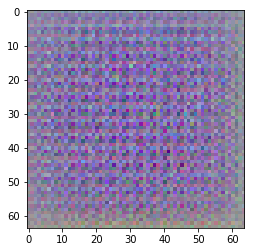

In [28]:
# img = imgs[0]
# plt.imshow(img)
plt.imshow(array_to_img(generatedImages[0]))

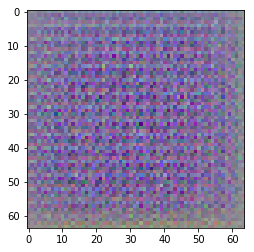

In [30]:
# img = imgs[1]
plt.imshow(array_to_img(generatedImages[1]))

In [32]:
img = imgs[2]
plt.imshow(img)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [95]:
for i in range(generatedImages.shape[0]):
    generatedImages[i] = img_to_array(array_to_img(generatedImages[i]))

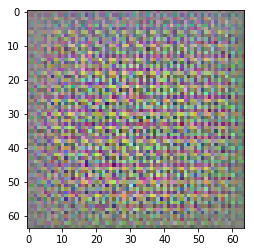

In [96]:
plt.imshow(generatedImages[0])

In [44]:
for batch, label in train_generator:
    img_real = batch[0]
    break

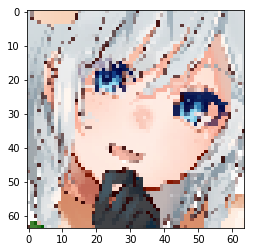

In [33]:
plt.imshow(pil_img)

In [13]:
def data_generator(batch_size, train_data_directory):
    train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_directory,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='binary')
    
    return train_generator

def build_network(input_shape, noise_shape):
    discriminator = AnimeDiscriminatorFactory().build(input_shape)
    generator = AnimeGeneratorFactory().build(noise_shape)
    
    gan_inputs = Input(noise_shape)
    generator_outputs = generator(gan_inputs)
    gan_outputs = discriminator(generator_outputs)
    gan = Model(inputs=gan_inputs, outputs=gan_outputs)
    gan.compile(loss = "binary_crossentropy",
                optimizer = "adam",
                metrics=["accuracy"])
    return (discriminator, generator, gan)
    
def execute(epochs, batch_size, input_shape, noise_shape, train_generator, discriminator, generator, gan):
    e = 1
    d_losses = []
    g_losses = []
    for batch, label in train_generator:
        dloss = 0
        gloss = 0
        
        print('-'*15, 'Epoch %d' % e, '-'*15)
        
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=(batch_size, ) + noise_shape)
        generated_images = generator.predict(noise)
        images = np.concatenate([batch, generated_images])

        # Labels for generated and real data
        discriminator_labels = np.concatenate((label, np.ones(batch_size)))

        # Train discriminator
        print("discriminator start...", end="")
        discriminator.trainable = True
        d_loss, d_acc = discriminator.train_on_batch(images, discriminator_labels)
        print("done")

        # Train generator
        print("generator start...", end="")
        noise = np.random.normal(0, 1, size=(batch_size, ) + noise_shape)
        discriminator.trainable = False
        g_loss, g_acc = gan.train_on_batch(noise, labels)
        print("done")

        # Store loss of most recent batch from this epoch
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        print("dloss: ", (d_loss, d_acc))
        print("gloss: ", (g_loss, g_acc))

        if e % 1000 == 0:
            print("saving generated image...", end="")
            for i in range(generated_images.shape[0]):
                g_image = array_to_img(generated_images[i])
                g_image.save("./collected_data/gan_generated_image_epoch_{0}_{1}.png".format(e, i))
            print("done")

        if e == 1 or e % 20 == 0:
            print("saving model...", end="")
            saveModels(e)
            print("done")

        # Plot losses from every epoch
        # print("plotting losses...", end="")
        # plotLoss(e)
        # print("done")

        if e >= epochs:
            break
        e += 1
    
def train(epochs, batch_size, input_shape, noise_shape, train_data_directory):
    train_generator = data_generator(batch_size, train_data_directory)
    discriminator, generator, gan = build_network(input_shape, noise_shape)
    execute(epochs, batch_size, input_shape, noise_shape,
            train_generator, discriminator, generator, gan)
    
    

In [14]:
train(1, 1, (64, 64, 3), (1, 1, 128), "../dataset-download/faces/")

Found 521 images belonging to 1 classes.
--------------- Epoch 1 ---------------


KeyboardInterrupt: 

In [79]:
import os
from keras.layers import BatchNormalization, LeakyReLU, Add, Flatten, Conv2D, Conv2DTranspose, Dense, Activation, Reshape
from keras.models import Input, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

#### --- for hinton
import tensorflow as tf
from keras import backend as K  # needed for mixing TensorFlow and Keras commands
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(config=config)
K.set_session(sess)
####

class Subpixel(Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 r,
                 padding="same",
                 data_format=None,
                 strides=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer="glorot_uniform",
                 bias_initializer="zeros",
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Subpixel, self).__init__(
            filters=r * r * filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.r = r

    def _phase_shift(self, I):
        r = self.r
        bsize, a, b, c = I.get_shape().as_list()
        # Handling Dimension(None) type for undefined batch dim
        bsize = K.shape(I)[0]
        # bsize, a, b, c/(r*r), r, r
        X = K.reshape(I, [bsize, a, b, int(c / (r * r)), r, r])
        # bsize, a, b, r, r, c/(r*r)
        X = K.permute_dimensions(X, (0, 1, 2, 5, 4, 3))
        # Keras backend does not support tf.split, so in future versions this could be nicer
        X = [X[:, i, :, :, :, :]
             for i in range(a)]  # a, [bsize, b, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, b, a*r, r, c/(r*r)
        X = [X[:, i, :, :, :] for i in range(b)]  # b, [bsize, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, a*r, b*r, c/(r*r)
        return X

    def call(self, inputs):
        return self._phase_shift(super(Subpixel, self).call(inputs))

    def compute_output_shape(self, input_shape):
        unshifted = super(Subpixel, self).compute_output_shape(input_shape)
        return (unshifted[0], int(self.r * unshifted[1]), int(self.r * unshifted[2]), int(unshifted[3] / (self.r * self.r)))

    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop("rank")
        config.pop("dilation_rate")
        config["filters"] /= int(self.r * self.r)
        config["r"] = self.r
        return config


class AnimeGeneratorFactory():
    def build(self, input_shape):
        """
            Returns a generator Model described here: https://arxiv.org/pdf/1708.05509.pdf

            Args:
                input_same: A 3 length tuple describing (width, height, channel)

            Output:
                Keras Model
        """

        def residual_block(layer, filters, momentum):
            """
                Residual Block consisting of
                    Conv2D -> Batch Normalization -> relu -> Conv2D -> Batch Normalization -> Residual Addition

                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """
            shortcut = layer
            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)
            layer = Activation("relu")(layer)
            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)

            layer = Add()([layer, shortcut])
            return layer

        def residual_layer(layer, number, filters, momentum):
            """
                Facade for residual block.

                Creates Residual layer with specified number of residual blocks

                Args:
                    layer:   Keras layer
                    number:  number of residual blocks in layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = residual_block(layer, filters, momentum)
            return layer

        def subpixel_block(layer, filters, momentum):
            """
                sub-pixel block consisting of
                    Conv2D -> pixel shuffler x 2 -> Batch Normalization -> Relu

                the code of subpixel layer is based on https://github.com/Tetrachrome/subpixel

                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """

            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)
            # r = upscale factor
            layer = Subpixel(filters=filters, kernel_size=(3, 3), r=2, padding="same")(layer)

            layer = BatchNormalization(momentum=momentum)(layer)
            layer = Activation("relu")(layer)
            return layer

        def subpixel_layer(layer, number, filters, momentum):
            """
                Facade for subpixel block.

                Creates subpixel layer with specified number of subpixel blocks

                Args:
                    layer:   Keras layer
                    number:  number of subpixel blocks in layer
                    filters: output size as an integer
                    momentum: variable for batch normalization

                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = subpixel_block(layer, filters, momentum)
            return layer

        MOMENTUM = 0.9
        DIM = 16
        DEPTH = 64
        NUM_RESIDUAL = 16
        NUM_SUBPIXEL = 2
        FINAL_FILTERS = 3
        INITIAL_FILTERS = 64

        inputs = Input(shape=input_shape)
        filters = INITIAL_FILTERS # 64

        layer = Dense(DEPTH * DIM * DIM)(inputs)
        layer = BatchNormalization(momentum=MOMENTUM)(layer)
        layer = Activation("relu")(layer)
        layer = Reshape((DIM, DIM, DEPTH))(layer)

        old = layer

        # 16 residual layers
        layer = residual_layer(layer, NUM_RESIDUAL, filters, MOMENTUM)

        layer = BatchNormalization(momentum=MOMENTUM)(layer)
        layer = Activation("relu")(layer)
        layer = Add()([layer, old])

        filters *= 4
        # 3 sub-pixel layers
        layer = subpixel_layer(layer, NUM_SUBPIXEL, filters, MOMENTUM)

        layer = Conv2D(filters=FINAL_FILTERS, kernel_size=(
            9, 9), strides=(1, 1), padding="same")(layer)
        layer = Activation("tanh")(layer)

        model = Model(inputs=inputs, outputs=layer)
        # optimizer = Adam(lr=0.0002, beta_1=0.5)
        # model.compile(loss="binary_crossentropy",
        #               optimizer=optimizer,
        #               metrics=["accuracy"])
        return model


class AnimeDiscriminatorFactory(object):
    """
        Discriminator Factory Class that creates the model described here:
        https://arxiv.org/pdf/1708.05509.pdf
    """

    def build(self, input_shape):
        """
            Returns a Model described here: https://arxiv.org/pdf/1708.05509.pdf
            Args:
                input_same: A 3 length tuple describing (width, height, channel)
            Output:
                Keras Model
        """

        RESIDUAL_BLOCKS_PER_LAYER = 2
        LEAKY_RELU_ALPHA = 0.2
        MODULES = 5

        def intermediate_layer(layer, filters, kernel_size):
            """
                Create the intermediate layers between residual layers.
                Args:
                    layer:       Keras layer
                    filters:     output size as an integer
                    kernel_size: length 2 tuple
                Returns:
                    Keras layer
            """
            layer = Conv2D(filters=filters, kernel_size=kernel_size,
                           strides=(2, 2), padding="same")(layer)
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            return layer

        def initial_layer(input_layer):
            """
                Facade for intermediate_layer for the first layer of the network.
                Args:
                    input_layer: Keras Input Layer
                Returns:
                    Keras layer
            """
            INITIAL_LAYER_FILTER = 32
            INITIAL_KERNEL_SIZE = (4, 4)
            return intermediate_layer(input_layer, INITIAL_LAYER_FILTER, INITIAL_KERNEL_SIZE)

        def residual_block(layer, filters):
            """
                Residual Block consisting of
                    Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> Residual Addition
                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                Returns:
                    Keras layer
            """
            shortcut = layer
            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)

            layer = Add()([layer, shortcut])
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            return layer

        def residual_layer(layer, number, filters):
            """
                Facade for residual block.
                Creates Residual layer with specified number of residual blocks
                Args:
                    layer:   Keras layer
                    number:  number of residual blocks in layer
                    filters: output size as an integer
                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = residual_block(layer, filters)
            return layer

        # NOTE: notation kxnysz
        # - k specifies that the convolution layer has kernel_size x
        # - n specifies that the convolution layer has y feature maps
        # - s specifies that the convolution layer has stride z

        inputs = Input(shape=input_shape)

        filters = 32
        # initial layer k4n32s2
        layer = initial_layer(inputs)
        for i in range(MODULES):
            layer = residual_layer(layer, RESIDUAL_BLOCKS_PER_LAYER, filters)
            filters *= 2

            intermediate_kernel_size = (3, 3)
            if i < 2:
                intermediate_kernel_size = (4, 4)
            layer = intermediate_layer(layer, filters, intermediate_kernel_size)

        layer = Dense(1, activation="sigmoid")(layer)
        outputs = Reshape((1, ))(layer)

        model = Model(inputs=inputs, outputs=outputs)
        return model

def setup():
    if not os.path.isdir("./images"):
        os.makedirs("./images")
        print("[ INFO ] images directory created")
    if not os.path.isdir("./saved_models"):
        os.makedirs("./saved_models")
        print("[ INFO ] saved_models directory created")

def data_generator(batch_size, train_data_directory):
    train_datagen = ImageDataGenerator(shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
    train_generator = train_datagen.flow_from_directory(train_data_directory,
                                                        target_size=(64, 64),
                                                        batch_size=batch_size,
                                                        class_mode="binary")
    return train_generator


def build_network(input_shape, noise_size, lambda_param):
    discriminator = AnimeDiscriminatorFactory().build(input_shape)
    generator = AnimeGeneratorFactory().build((noise_size, ))

    # Compute Wasserstein Loss and Gradient Penalty
    d_real_input = Input(shape=input_shape)
    noise = Input(shape=(noise_size, )) # Ex: shape = (128, )
    d_fake_input = generator(noise)

    epsilon_input = K.placeholder(shape=(None, ) + input_shape)
    d_mixed_input = Input(shape=input_shape, tensor=d_real_input + epsilon_input)

    loss_real = K.mean(discriminator(d_real_input))
    loss_fake = K.mean(discriminator(d_fake_input))

    gradient_mixed = K.gradients(discriminator(d_mixed_input), [d_mixed_input])[0]
    normalized_gradient_mixed = K.sqrt(K.sum(K.square(gradient_mixed), axis=[1, 2, 3]))
    gradient_penalty = K.mean(K.square(normalized_gradient_mixed - 1))

    loss = loss_fake - loss_real + (lambda_param * gradient_penalty)

    # Discriminator
    training_updates = Adam(lr=0.0002, beta_1=0.5).get_updates(discriminator.trainable_weights, [], loss)
    discriminator_train = K.function([d_real_input, noise, epsilon_input],
                                     [loss_real, loss_fake],
                                     training_updates)
    # Generator
    loss = -loss_fake
    training_updates = Adam(lr=0.0002, beta_1=0.5).get_updates(generator.trainable_weights, [], loss)
    generator_train = K.function([noise], [loss], training_updates)

    print("[ INFO ] finished building network")
    return (discriminator_train, generator_train)

# Save the generator and discriminator networks (and weights) for later use
def save_models(epoch, generator, discriminator):
    print("saving model...", end="")
    generator.save("./collected_models/gan_generator_epoch_{0}.h5".format(epoch))
    discriminator.save("./collected_models/gan_discriminator_epoch_{0}.h5".format(epoch))
    gan.save("./collected_models/gan_core_epoch_{0}.h5".format(epoch))
    print("done")

def save_images(images, epoch):
    for i in range(images.shape[0]):
        g_image = array_to_img(images[i])
        g_image.save("./images/generated_image_{0}_{1}_{2}.png".format(epoch, generation, i))

def execute2(epochs, batch_size, noise_size, train_generator, discriminator, generator):
    generation = 0
    noise_shape = (batch_size, noise_size)
    fixed_noise = np.random.normal(size=noise_shape).astype("float32")
    batches = train_generator.samples // batch_size

    g_error = 0
    epoch = 0
    while epoch < epochs:
        batch_counter = 0
        for batch, label in train_generator:
            # Leave after finishing all batches or executing for 100 cycles.
            if batch.shape[0] != batch_size:
                print("[ INFO ] Epoch Completed {0}".format(epoch))
                epoch += 1
                break
            elif batch_counter >= 100:
                print("[ INFO ] Trained on {0} Batches".format(batch_counter))
                break

            real_data = batch
            noise = np.random.normal(size=noise_shape)
            epsilon = real_data.std() * np.random.uniform(-0.5, 0.5, size=real_data.shape)
            epsilon *= np.random.uniform(size=(batch_size, 1, 1, 1))

            d_real_error, d_fake_error = discriminator([real_data, noise, epsilon])
            d_error = d_real_error - d_fake_error

            batch_counter += 1


        if generation % 500 == 0:
            print("[{0}/{1}][{2}/{3}] d_loss: {4} g_loss: {5} d_real: {6}, d_fake: {7}".format(epoch, epochs, batch_counter, batches, d_error, g_error, d_real_error, d_fake_error))
            fake = generator.predict(fixed_noise)
            save_images(fake, epoch, generation)
            # TODO: figure out how to save Keras Functions
            # save_models(epoch, generator, discriminator)

        noise = np.random.normal(size=noise_shape)
        g_error = generator([noise])
        generation += 1



def train2(epochs, batch_size, input_shape, noise_size, lambda_param, train_data_directory):
    setup()
    train_generator = data_generator(batch_size, train_data_directory)
    # Outputs Keras functions that takes inputs:
    # discriminator(real_input, noise, epsilon)
    # Inputs:
    #       - real_input = same as input_shape
    #       - noise = (batch_size, noise_size)
    #       - epsilon = (None, batch_size, ) + input_shape -- a 5D tensor (really 4D)
    # Outputs:
    #       - (discriminator_real_error, discriminator_fake_error)
    #
    # generator(noise)
    # Inputs:
    #       - noise = same as for discriminator
    # Outputs:
    #       - generator_error
    discriminator, generator = build_network(input_shape, noise_size, lambda_param)
    execute2(epochs, batch_size, noise_size, train_generator, discriminator, generator)


def main():
    print("[ INFO ] Initialized")
    train2(100000, 32, (64, 64, 3), 128, 10, "../dataset-download/faces")

if __name__ == "__main__":
    main()


[ INFO ] Initialized
Found 521 images belonging to 1 classes.
[ INFO ] finished building network


InvalidArgumentError: You must feed a value for placeholder tensor 'batch_normalization_1/keras_learning_phase' with dtype bool
	 [[Node: batch_normalization_1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'batch_normalization_1/keras_learning_phase', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-5db9ea6ecdd8>", line 1, in <module>
    generator = AnimeGeneratorFactory().build((128, ))
  File "<ipython-input-22-1bc81a09dc4d>", line 112, in build
    layer = BatchNormalization(momentum=MOMENTUM)(layer)
  File "/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/keras/layers/normalization.py", line 190, in call
    training=training)
  File "/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2610, in in_train_phase
    training = learning_phase()
  File "/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 115, in learning_phase
    name='keras_learning_phase')
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1507, in placeholder
    name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'batch_normalization_1/keras_learning_phase' with dtype bool
	 [[Node: batch_normalization_1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [80]:
d, g = build_network((64, 64, 3), 128, 10)

[ INFO ] finished building network
